<a href="https://www.kaggle.com/code/hityangzijian/dinn-sird-baseline?scriptVersionId=95690678" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
#import libaries
import torch
from torch.autograd import grad
import torch.nn as nn
from numpy import genfromtxt
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import pandas as pd 
import os
import re
from scipy.integrate import odeint
import numpy as np

torch.manual_seed(1234)

# Data making part #

In [2]:
# Data reading and accumulation
cumulative_infected_list = []
cumulative_dead_list = []
cumulative_recovered_list = []

daily_infected_list = []
daily_dead_list = []
daily_recovered_list = []

fnames = os.listdir('../input/cssegisanddatacovid19/csse_covid_19_data/csse_covid_19_daily_reports')
try:
    fnames.remove('README.md')
    fnames.remove('.gitignore')
except:
    pass
#order file names
def sortkey(x):
    parts = re.split('-', x.replace(".csv", ""))
    #print(parts)
    return [int(parts[2]), int(parts[0]), int(parts[1])]

sorted_fnames = sorted(fnames, key=sortkey)

for file_name in sorted_fnames:
    df = pd.read_csv(f'../input/cssegisanddatacovid19/csse_covid_19_data/csse_covid_19_daily_reports/{file_name}')
    try:
        df = df.set_index('Country_Region')
    except:
        df = df.set_index('Country/Region')
    df.replace(np.nan, 0)
    deaths = 0 
    confirmed = 0 
    recovered = 0
    for key,row in df.iterrows():
        if key == 'Bahrain':
            deaths = deaths + row['Deaths']
            confirmed = confirmed + row['Confirmed']
            recovered = recovered + row['Recovered']

    cumulative_infected_list.append(confirmed)
    cumulative_dead_list.append(deaths)
    cumulative_recovered_list.append(recovered)

for day in range(1,len(cumulative_infected_list)):
    daily_infected_list.append(cumulative_infected_list[day]- cumulative_infected_list[day-1])
    daily_dead_list.append(cumulative_dead_list[day]- cumulative_dead_list[day-1])
    daily_recovered_list.append(cumulative_recovered_list[day]- cumulative_recovered_list[day-1])   

In [3]:
#remove negative outliers
new_daily_recovered_list = daily_recovered_list.copy() 

for n, i in enumerate(new_daily_recovered_list):
    if i < 0:
        new_daily_recovered_list[n] = new_daily_recovered_list[n-1]

In [4]:
# remove very high outliers --> run twice -- seems like an outlier (indices 263, 264)
# max_value_idx = new_daily_recovered_list.index(max(new_daily_recovered_list))
# new_daily_recovered_list[max_value_idx] = new_daily_recovered_list[max_value_idx - 1]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  # This is added back by InteractiveShellApp.init_path()


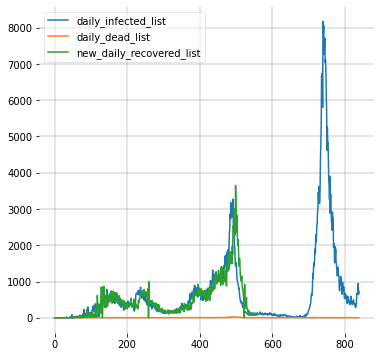

In [5]:
# Origin data visualization
fig = plt.figure(figsize=(6,6))

ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.set_facecolor('xkcd:white')

plt.plot(daily_infected_list, label = 'daily_infected_list')
plt.plot(daily_dead_list, label = 'daily_dead_list')
plt.plot(daily_recovered_list, label = 'new_daily_recovered_list')

ax.grid(b=True, which='major', c='black', lw=0.2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show();

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.


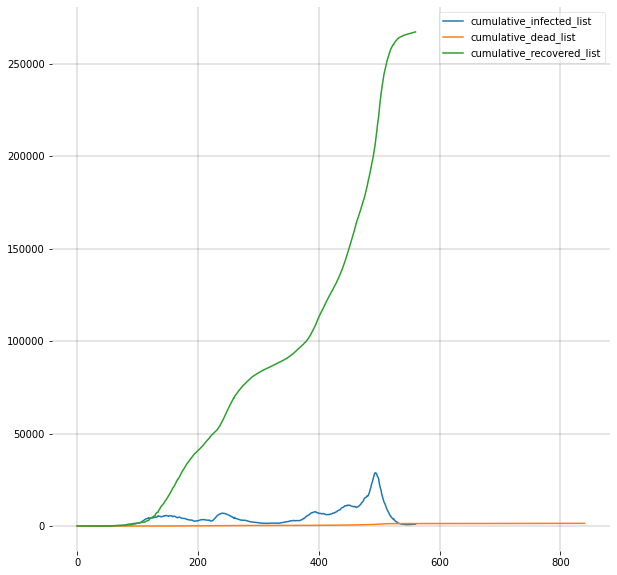

841


In [6]:
# Making the SIDR list
N = 1569446
cumulative_susceptible_list = []
for i in range(len(cumulative_recovered_list)):
    cumulative_infected_list[i]=(cumulative_infected_list[i] - cumulative_recovered_list[i]- cumulative_dead_list[i])
    cumulative_susceptible_list.append(N - cumulative_recovered_list[i] - cumulative_infected_list[i] - cumulative_dead_list[i])

fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.set_facecolor('xkcd:white')

# plt.plot(cumulative_susceptible_list[:310], label = 'cumulative_susceptible_list')
plt.plot(cumulative_infected_list, label = 'cumulative_infected_list')
plt.plot(cumulative_dead_list, label = 'cumulative_dead_list')
plt.plot(cumulative_recovered_list, label = 'cumulative_recovered_list')

ax.grid(b=True, which='major', c='black', lw=0.2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show();
print(len(cumulative_susceptible_list))

In [7]:
#save as csv files

#cumulative cases [S,I,D,R]
df = pd.DataFrame(list(zip(cumulative_susceptible_list, cumulative_infected_list, cumulative_dead_list, cumulative_recovered_list)),
               columns =['cumulative_susceptible', 'cumulative_infected', 'cumulative_dead', 'cumulative_recovered'])
df.to_csv('covid_real_data_cumulative_cases.csv')

#daily cases [I,D,R]
df = pd.DataFrame(list(zip(daily_infected_list, daily_dead_list, new_daily_recovered_list)),
               columns =['daily_infected', 'daily_dead', 'daily_recovered'])
df.to_csv('covid_real_data_daily_cases.csv')

# Data Reading and visualization #

In [8]:
#read data
covid_cumulative_cases = pd.read_csv('./covid_real_data_cumulative_cases.csv', delimiter=',') #in the form of [t,S,I,D,R。。。]
covid_cumulative_cases.columns = ['t', 'cumulative_susceptible','cumulative_infected', 'cumulative_dead', 'cumulative_recovered'] #rename columns
covid_cumulative_cases['t'] = covid_cumulative_cases['t'].astype(float)
#covid_cumulative_cases = covid_cumulative_cases[9:]
covid_cumulative_cases

,t,cumulative_susceptible,cumulative_infected,cumulative_dead,cumulative_recovered
0,0.0,1569446.0,0.0,0.0,0.0
1,1.0,1569446.0,0.0,0.0,0.0
2,2.0,1569446.0,0.0,0.0,0.0
3,3.0,1569446.0,0.0,0.0,0.0
4,4.0,1569446.0,0.0,0.0,0.0
...,...,...,...,...,...
836,836.0,NaN,NaN,1477.0,NaN
837,837.0,NaN,NaN,1477.0,NaN
838,838.0,NaN,NaN,1477.0,NaN
839,839.0,NaN,NaN,1477.0,NaN


In [9]:
cumulative_susceptible = []
cumulative_infected = [] 
cumulative_dead = []
cumulative_recovered = []
timesteps = []

# set the dataset here !
DAYS = 570
timestep = 0
ratio = 0.9

d1 = covid_cumulative_cases['cumulative_susceptible'][:DAYS]
d2 = covid_cumulative_cases['cumulative_infected'][:DAYS]
d3 = covid_cumulative_cases['cumulative_dead'][:DAYS]
d4 = covid_cumulative_cases['cumulative_recovered'][:DAYS]
d5 = covid_cumulative_cases['t'][:DAYS]

for item in range(len(d5)):
    try:
        if item%timestep == 0:
            cumulative_susceptible.append(d1[item])
            cumulative_infected.append(d2[item]) 
            cumulative_dead.append(d3[item])
            cumulative_recovered.append(d4[item])
            timesteps.append(d5[item])

    except:
            cumulative_susceptible.append(d1[item])
            cumulative_infected.append(d2[item]) 
            cumulative_dead.append(d3[item])
            cumulative_recovered.append(d4[item])
            timesteps.append(d5[item])
            
datasize = len(timesteps)
trainsize = int(datasize * ratio)
print('datasize is:',datasize)
print('trainsize is:',trainsize)

datasize is: 570
trainsize is: 513


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  app.launch_new_instance()


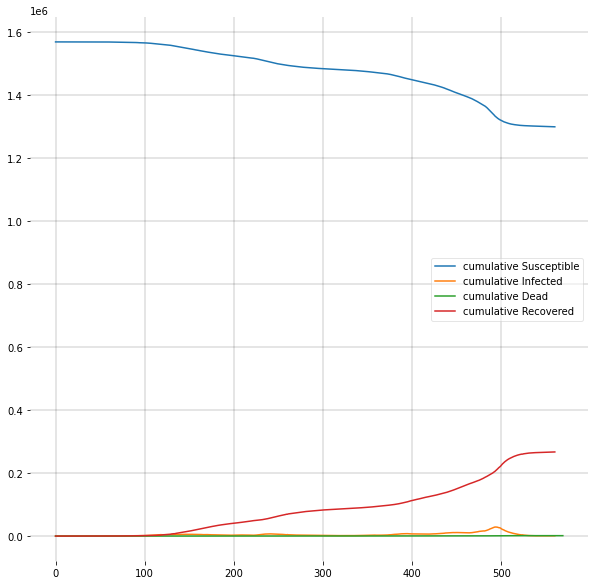

In [10]:
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.set_facecolor('xkcd:white')

#plt.plot(covid_cumulative_cases['cumulative_susceptible'][:DAYS], label = 'cumulative Susceptible')
#plt.plot(covid_cumulative_cases['cumulative_infected'][:DAYS], label = 'cumulative Infected')
#plt.plot(covid_cumulative_cases['cumulative_dead'][:DAYS], label = 'cumulative Dead')
#plt.plot(covid_cumulative_cases['cumulative_recovered'][:DAYS], label = 'cumulative Recovered')

plt.plot(cumulative_susceptible, label = 'cumulative Susceptible')
plt.plot(cumulative_infected, label = 'cumulative Infected')
plt.plot(cumulative_dead, label = 'cumulative Dead')
plt.plot(cumulative_recovered, label = 'cumulative Recovered')

ax.grid(b=True, which='major', c='black', lw=0.2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show();

# Network part #

In [11]:
%%time

PATH = 'covid_real_data_cumulative_cases' 

class DINN(nn.Module):
    def __init__(self, t, S_data, I_data, D_data, R_data): #[t,S,I,D,R]
        super(DINN, self).__init__()
        self.N = 340e6 #population size
        self.t = torch.tensor(t, requires_grad=True)
        self.t_float = self.t.float()
        self.t_batch = torch.reshape(self.t_float, (len(self.t),1)) #reshape for batch 
        self.S = torch.tensor(S_data)
        self.I = torch.tensor(I_data)
        self.D = torch.tensor(D_data)
        self.R = torch.tensor(R_data)

        self.losses = []
        self.errors = []
        self.save = 3 #which file to save to

        self.alpha_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True)) #0.191
        self.beta_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True)) #0.05
        self.gamma_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True)) #0.0294
        
        #find values for normalization
        self.S_max = max(self.S)
        self.I_max = max(self.I)
        self.D_max = max(self.D)
        self.R_max = max(self.R)
        self.S_min = min(self.S)
        self.I_min = min(self.I)
        self.D_min = min(self.D)
        self.R_min = min(self.R)

        #unnormalize
        self.S_hat = (self.S - self.S_min) / (self.S_max - self.S_min)
        self.I_hat = (self.I - self.I_min) / (self.I_max - self.I_min)
        self.D_hat = (self.D - self.D_min) / (self.D_max - self.D_min)
        self.R_hat = (self.R - self.R_min) / (self.R_max - self.R_min)

        #matrices (x4 for S,I,D,R) for the gradients
        self.m1 = torch.zeros((len(self.t), 4)); self.m1[:, 0] = 1
        self.m2 = torch.zeros((len(self.t), 4)); self.m2[:, 1] = 1
        self.m3 = torch.zeros((len(self.t), 4)); self.m3[:, 2] = 1
        self.m4 = torch.zeros((len(self.t), 4)); self.m4[:, 3] = 1

        #NN
        self.net_sidr = self.Net_sidr()
        self.params = list(self.net_sidr.parameters())
        self.params.extend(list([self.alpha_tilda, self.beta_tilda, self.gamma_tilda]))

    #force parameters to be in a range
    @property
    def alpha(self):
        return torch.tanh(self.alpha_tilda)

    @property
    def beta(self):
        return torch.tanh(self.beta_tilda)
    
    @property
    def gamma(self):
        return torch.tanh(self.gamma_tilda)


    #nets
    class Net_sidr(nn.Module): # input = [t]
        def __init__(self):
            super(DINN.Net_sidr, self).__init__()
            self.fc1=nn.Linear(1, 20) 
            self.fc2=nn.Linear(20, 20)
            self.fc3=nn.Linear(20, 20)
            self.fc4=nn.Linear(20, 20)
            self.fc5=nn.Linear(20, 20)
            self.fc6=nn.Linear(20, 20)
            self.fc7=nn.Linear(20, 20)
            self.fc8=nn.Linear(20, 20)
            self.out=nn.Linear(20, 4) #outputs S, I, D, R

        def forward(self, t_batch):
            sidr=F.relu(self.fc1(t_batch))
            sidr=F.relu(self.fc2(sidr))
            sidr=F.relu(self.fc3(sidr))
            sidr=F.relu(self.fc4(sidr))
            sidr=F.relu(self.fc5(sidr))
            sidr=F.relu(self.fc6(sidr))
            sidr=F.relu(self.fc7(sidr))
            sidr=F.relu(self.fc8(sidr))
            sidr=self.out(sidr)
            return sidr
            
    def net_f(self, t_batch):
        sidr_hat = self.net_sidr(t_batch)

        S_hat, I_hat, D_hat, R_hat = sidr_hat[:,0], sidr_hat[:,1], sidr_hat[:,2], sidr_hat[:,3]

        #S_t
        sidr_hat.backward(self.m1, retain_graph=True)
        
        S_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #I_t
        sidr_hat.backward(self.m2, retain_graph=True)
        
        I_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #D_t
        sidr_hat.backward(self.m3, retain_graph=True)
        
        D_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #R_t
        sidr_hat.backward(self.m4, retain_graph=True)
        
        R_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #unnormalize
        S = self.S_min + (self.S_max - self.S_min) * S_hat
        I = self.I_min + (self.I_max - self.I_min) * I_hat
        D = self.D_min + (self.D_max - self.D_min) * D_hat      
        R = self.R_min + (self.R_max - self.R_min) * R_hat

        f1_hat = S_hat_t - (-(self.alpha / self.N) * S * I)  / (self.S_max - self.S_min)
        f2_hat = I_hat_t - ((self.alpha / self.N) * S * I - self.beta * I - self.gamma * I ) / (self.I_max - self.I_min)
        f3_hat = D_hat_t - (self.gamma * I) / (self.D_max - self.D_min)
        f4_hat = R_hat_t - (self.beta * I ) / (self.R_max - self.R_min)


        return f1_hat, f2_hat, f3_hat, f4_hat, S_hat, I_hat, D_hat, R_hat
    
    def load(self):
      # Load checkpoint
      try:
        checkpoint = torch.load(PATH + str(self.save)+'.pt') 
        print('\nloading pre-trained model...')
        self.load_state_dict(checkpoint['model'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler'])
        epoch = checkpoint['epoch']
         
        self.losses = checkpoint['losses']
         

      except RuntimeError :
          print('changed the architecture, ignore')
          pass
      except FileNotFoundError:
          pass
    
    def calculate_RSM(data,pred,size):
        torch.mean(torch.square(data[:size] - pred[:size]))
        
    def train(self, n_epochs):
      #try loading
      self.load()

      #train
      print('\nstarting training...\n')
      
      for epoch in range(n_epochs):
        #lists to hold the output (maintain only the final epoch)
        S_pred_list = []
        I_pred_list = []
        D_pred_list = []
        R_pred_list = []

         
        f1, f2, f3, f4, S_pred, I_pred, D_pred, R_pred = self.net_f(self.t_batch)
        self.optimizer.zero_grad()

        S_pred_list.append(self.S_min + (self.S_max - self.S_min) * S_pred) 
        I_pred_list.append(self.I_min + (self.I_max - self.I_min) * I_pred)
        D_pred_list.append(self.D_min + (self.D_max - self.D_min) * D_pred)
        R_pred_list.append(self.R_min + (self.R_max - self.R_min) * R_pred)
    
        loss = (torch.mean(torch.square(self.S_hat[:trainsize] - S_pred[:trainsize]))+ 
                torch.mean(torch.square(self.I_hat[:trainsize] - I_pred[:trainsize]))+
                torch.mean(torch.square(self.D_hat[:trainsize] - D_pred[:trainsize]))+
                torch.mean(torch.square(self.R_hat[:trainsize] - R_pred[:trainsize]))+
                torch.mean(torch.square(f1[:trainsize]))+
                torch.mean(torch.square(f2[:trainsize]))+
                torch.mean(torch.square(f3[:trainsize]))+
                torch.mean(torch.square(f4[:trainsize]))
                ) 
        error = (torch.mean(torch.square(self.S_hat[trainsize:] - S_pred[trainsize:]))+ 
                torch.mean(torch.square(self.I_hat[trainsize:] - I_pred[trainsize:]))+
                torch.mean(torch.square(self.D_hat[trainsize:] - D_pred[trainsize:]))+
                torch.mean(torch.square(self.R_hat[trainsize:] - R_pred[trainsize:]))+
                torch.mean(torch.square(f1[trainsize:]))+
                torch.mean(torch.square(f2[trainsize:]))+
                torch.mean(torch.square(f3[trainsize:]))+
                torch.mean(torch.square(f4[trainsize:]))
                ) 

        #error.backward(retain_graph=True)
        loss.backward()
        self.optimizer.step()
        self.scheduler.step() 
         
         

        self.losses.append(loss.item())
        self.errors.append(error.item())

        #if epoch % 1000 == 0:          
          #print('\nEpoch ', epoch)

        #loss + model parameters update
        if epoch % 5000 == 0:
          #checkpoint save every 100 epochs if the loss is lower
          print('\nSaving model... Loss is:', loss,'error is:',error)
          torch.save({
              'epoch': epoch,
              'model': self.state_dict(),
              'optimizer_state_dict': self.optimizer.state_dict(),
              'scheduler': self.scheduler.state_dict(),
              #'loss': loss,
              'losses': self.losses,
              'error':self.errors
              }, PATH + str(self.save)+'.pt')
          if self.save % 2 > 0: #its on 3
            self.save = 2 #change to 2
          else: #its on 2
            self.save = 3 #change to 3

          print('epoch: ', epoch)
        

      return S_pred_list, I_pred_list, D_pred_list, R_pred_list

CPU times: user 59 µs, sys: 0 ns, total: 59 µs
Wall time: 64.6 µs


# Training part #

In [12]:
%%time

dinn = DINN(timesteps, cumulative_susceptible, cumulative_infected, cumulative_dead, cumulative_recovered) #in the form of [t,S,I,D,R]

learning_rate = 1e-5
optimizer = optim.Adam(dinn.params, lr = learning_rate)
dinn.optimizer = optimizer


scheduler = torch.optim.lr_scheduler.CyclicLR(dinn.optimizer, base_lr=1e-5, max_lr=1e-3, step_size_up=1000, mode="exp_range", gamma=0.85, cycle_momentum=False)

dinn.scheduler = scheduler

try:
    S_pred_list, I_pred_list, D_pred_list, R_pred_list = dinn.train(500000) #train
except EOFError:
    if dinn.save == 2:
        dinn.save = 3
        S_pred_list, I_pred_list, D_pred_list, R_pred_list = dinn.train(500000) #train
    elif dinn.save == 3:
        dinn.save = 2
        S_pred_list, I_pred_list, D_pred_list, R_pred_list = dinn.train(500000) #train


starting training...


Saving model... Loss is: tensor(0.6780, dtype=torch.float64, grad_fn=<AddBackward0>) error is: tensor(nan, dtype=torch.float64, grad_fn=<AddBackward0>)
epoch:  0

Saving model... Loss is: tensor(0.1683, dtype=torch.float64, grad_fn=<AddBackward0>) error is: tensor(nan, dtype=torch.float64, grad_fn=<AddBackward0>)
epoch:  5000

Saving model... Loss is: tensor(0.0727, dtype=torch.float64, grad_fn=<AddBackward0>) error is: tensor(nan, dtype=torch.float64, grad_fn=<AddBackward0>)
epoch:  10000

Saving model... Loss is: tensor(0.0607, dtype=torch.float64, grad_fn=<AddBackward0>) error is: tensor(nan, dtype=torch.float64, grad_fn=<AddBackward0>)
epoch:  15000

Saving model... Loss is: tensor(0.0330, dtype=torch.float64, grad_fn=<AddBackward0>) error is: tensor(nan, dtype=torch.float64, grad_fn=<AddBackward0>)
epoch:  20000

Saving model... Loss is: tensor(0.0062, dtype=torch.float64, grad_fn=<AddBackward0>) error is: tensor(nan, dtype=torch.float64, grad_fn=<AddBackwa

# Evalution part #

Text(0, 0.5, 'RSM')

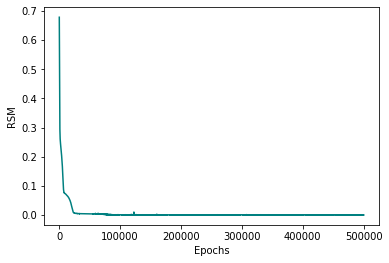

In [13]:
plt.plot(dinn.losses[0:], color = 'teal')
plt.plot(dinn.errors[0:], color = 'gold')
plt.xlabel('Epochs')
plt.ylabel('RSM')

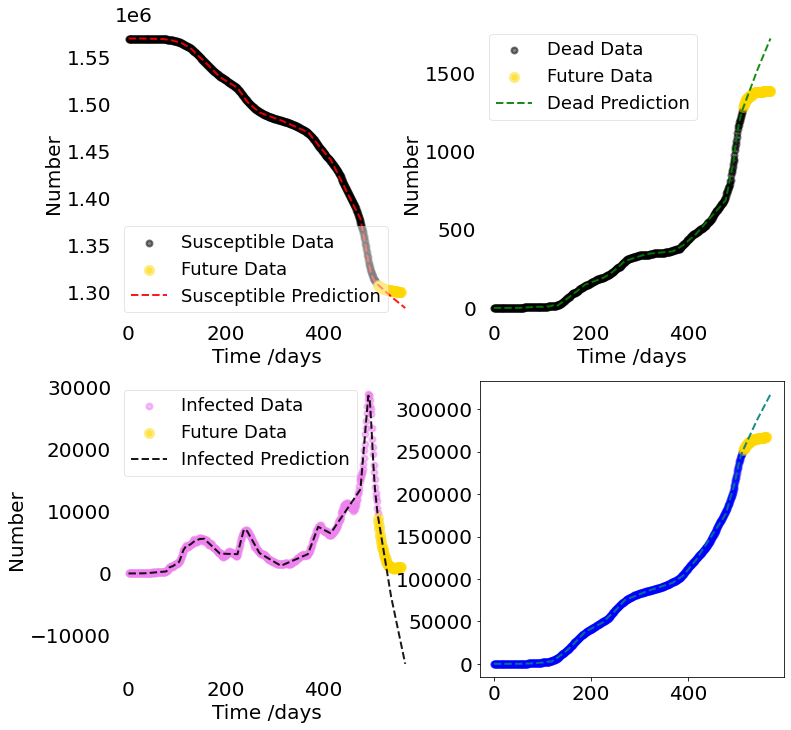

In [14]:
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 

fig, ax = plt.subplots(2, 2, figsize = (12,12))


ax[0, 0].set_facecolor('xkcd:white')
ax[1, 0].set_facecolor('xkcd:white')
ax[0, 1].set_facecolor('xkcd:white')
ax[1, 1].set_facecolor('xkcd:white')


ax[0, 0].scatter(timesteps[:trainsize], cumulative_susceptible[:trainsize], c = 'black', alpha=0.5, lw=2, label='Susceptible Data')
ax[0, 0].scatter(timesteps[trainsize:], cumulative_susceptible[trainsize:], c = 'gold', alpha=0.5, lw=5, label='Future Data')
ax[0, 0].plot(timesteps, S_pred_list[0].detach().numpy(), 'red', alpha=0.9, lw=2, label='Susceptible Prediction', linestyle='dashed')

ax[1, 0].scatter(timesteps[:trainsize], cumulative_infected[:trainsize], c = 'violet', alpha=0.5, lw=2, label='Infected Data')
ax[1, 0].scatter(timesteps[trainsize:], cumulative_infected[trainsize:], c = 'gold', alpha=0.5, lw=5, label='Future Data')
ax[1, 0].plot(timesteps, I_pred_list[0].detach().numpy(), 'black', alpha=0.9, lw=2, label='Infected Prediction', linestyle='dashed')

ax[0, 1].scatter(timesteps[:trainsize], cumulative_dead[:trainsize], c = 'black', alpha=0.5, lw=2, label='Dead Data')
ax[0, 1].scatter(timesteps[trainsize:], cumulative_dead[trainsize:], c = 'gold', alpha=0.5, lw=5, label='Future Data')
ax[0, 1].plot(timesteps, D_pred_list[0].detach().numpy(), 'green', alpha=0.9, lw=2, label='Dead Prediction', linestyle='dashed')

ax[1, 1].scatter(timesteps[:trainsize], cumulative_recovered[:trainsize], c = 'blue', alpha=0.5, lw=2, label='Recovered Data')
ax[1, 1].scatter(timesteps[trainsize:], cumulative_recovered[trainsize:], c = 'gold', alpha=0.5, lw=5, label='Future Data')
ax[1, 1].plot(timesteps, R_pred_list[0].detach().numpy(), 'teal', alpha=0.9, lw=2, label='Recovered Prediction', linestyle='dashed')

ax[0, 0].set_xlabel('Time /days',size = 20)
ax[0, 0].set_ylabel('Number',size = 20)
ax[0, 0].yaxis.set_tick_params(length=0)
ax[0, 0].xaxis.set_tick_params(length=0)
# ax[0, 0].grid(b=True, which='major', c='black', lw=0.2, ls='-')
legend = ax[0, 0].legend(prop={'size':18})
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax[0, 0].spines[spine].set_visible(False)
############################################################
ax[1, 0].set_xlabel('Time /days',size = 20)
ax[1, 0].set_ylabel('Number',size = 20)
ax[1, 0].yaxis.set_tick_params(length=0)
ax[1, 0].xaxis.set_tick_params(length=0)
# ax[1, 0].grid(b=True, which='major', c='black', lw=0.2, ls='-')
legend = ax[1, 0].legend(prop={'size':18})
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax[1, 0].spines[spine].set_visible(False)
############################################################
ax[0, 1].set_xlabel('Time /days',size = 20)
ax[0, 1].set_ylabel('Number',size = 20)
ax[0, 1].yaxis.set_tick_params(length=0)
ax[0, 1].xaxis.set_tick_params(length=0)
# ax[0, 1].grid(b=True, which='major', c='black', lw=0.2, ls='-')
legend = ax[0, 1].legend(prop={'size':18})
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax[0, 1].spines[spine].set_visible(False)
############################################################
plt.savefig('covid_real_data_cumulative_cases.pdf')
plt.show()

In [15]:
print('dinn.alpha', dinn.alpha)
print('dinn.beta', dinn.beta)
print('dinn.gamma', dinn.gamma)

dinn.alpha tensor([0.9986], grad_fn=<TanhBackward>)
dinn.beta tensor([0.0029], grad_fn=<TanhBackward>)
dinn.gamma tensor([0.0006], grad_fn=<TanhBackward>)
